In [1]:
#!pip install eikon cufflinks

import eikon as ek                                                        # The Eikon Python wrapper package
import cufflinks as cf                                                    # Cufflinks
import configparser as cp
cf.set_config_file(offline = True)                                        # Set the plotting mode to offline

In [2]:
appkey = '845ed754fed84d55978ed414af0a7a69fe3ea66c'
ek.set_app_key(appkey)                                                     # Launch Eikon API with App key

In [3]:
# Define all useful functions

import datetime as dt
from matplotlib import pylab as plt, pylab
import numpy as np
import pandas as pd
from scipy.optimize import basinhopping

# Set up model's parameters
schwartz_smith = [
    'x0',
    'e0',
    'mue',
    'kappa',
    'lambdax',
    'sigmax',
    'sigmae',
    'pxe'
]


# Generic function to calibrate Schwartz & Smith model
def calibrate(Data, niter = 100):
    
    trade_date = Data['Trade date']
    maturity = Data['Contract expiry']
    forwards = Data['Close prices']
    
    maturities = calc_maturities(maturity, trade_date)
    
    # Initial parameters
    x0 = [0.1] * len(schwartz_smith)         
    
    # Function to minimize
    def objective(x0):
        schwartzftT, SSE = calc_schwartz(maturities, forwards, x0)
        return SSE
    
    # Boundary of Schwartz & Smith parameters
    bounds = [
        (0, 100),          # x0
        (0, 100),          # e0        
        (-1, 1),           # mue
        (0.0000001, 100),  # kappa
        (-5, 5),           # lambdax
        (0, 5),            # sigmax
        (0, 5),            # sigmae
        (-1, 1)            # pxe
    ]
 
    minimizer_kwargs = dict(method = "L-BFGS-B", bounds = bounds)
  
    # Run the "basin hopping" routine
    result = basinhopping(objective, x0, T = 0.5, stepsize = 0.1, niter = niter, minimizer_kwargs = minimizer_kwargs)
         
    return result
 

# Compute Forward prices according to parameters 
def calc_schwartz(maturities, forwards, schwartz_params):
    
    x0 = schwartz_params[0]
    e0 = schwartz_params[1]
    mue = schwartz_params[2]
    kappa = schwartz_params[3]    
    lambdax = schwartz_params[4]
    sigmax = schwartz_params[5]
    sigmae = schwartz_params[6]
    pxe = schwartz_params[7]
    
    # Calc Schw E[ln(S(T))]
    schwartzES = np.exp(- kappa * maturities) * x0 + e0 + mue *  maturities -  lambdax / kappa * \
                (1 - np.exp(- kappa * maturities))
                   
    # Calc Schw V[ln(S(T))]
    schwartzVS = 0.5 * ((1 - np.exp(-2 * kappa * maturities)) * (sigmax ** 2 / (2 * kappa)) + \
                 sigmae ** 2 * maturities + 2 * (1 - np.exp(- kappa * maturities)) * (pxe * sigmax * sigmae) / kappa)
 
    # Calc Schw F(t,T)
    schwartzftT = np.exp(schwartzES + schwartzVS)
    
    #  Sum of squares
    SSE = (schwartzftT - forwards) ** 2
 
    return schwartzftT, SSE.sum()
 

# Compute maturity horizon in years 
def calc_maturities(maturity, trade_date):
    convertMonthsToMaturities = (maturity - trade_date).dt.days / 365
    return convertMonthsToMaturities

In [19]:
                                                                          # List of RIC (Reuters Instrument Code)
RICs = ['ECEFDc1', 'CFI2c1', 'CFI2c2', 'CFI2c3', 'CFI2c4', 'CFI2c5', 'CFI2c6', 'CFI2c7', 'CFI2c8', 
        'CFI2c9', 'CFI2c10', 'CFI2c11', 'CFI2c12', 'CFI2c13', 'CFI2c14', 'CFI2c15'] 
EUA, err = ek.get_data(RICs, ['SETTLEDATE', 'EXPIR_DATE', 'CF_CLOSE'])    # Extract Refinitiv data
                                                                          # Convert date format
EUA['SETTLEDATE'] = pd.to_datetime(EUA['SETTLEDATE'], format = '%Y-%m-%d')
EUA['EXPIR_DATE'] = pd.to_datetime(EUA['EXPIR_DATE'], format = '%Y-%m-%d')

EUA.columns = ['Instrument', 'Trade date', 'Contract expiry', 'Close prices']

In [5]:
EUA

,Instrument,Trade date,Contract expiry,Close prices
0,ECEFDc1,2022-02-18,2022-02-18,85.94
1,CFI2c1,2022-02-18,2022-02-28,85.96
2,CFI2c2,2022-02-18,2022-03-28,85.98
3,CFI2c3,2022-02-18,2022-04-25,86.01
4,CFI2c4,2022-02-18,2022-06-27,86.11
5,CFI2c5,2022-02-18,2022-09-26,86.27
6,CFI2c6,2022-02-18,2022-12-19,86.44
7,CFI2c7,2022-02-18,2023-03-27,86.92
8,CFI2c8,2022-02-18,2023-06-26,87.27
9,CFI2c9,2022-02-18,2023-09-25,87.62


In [6]:
results = calibrate(EUA)                                                  # Calibrate the model 
                                                                          # Extract results
Schwartz_smith_params = pd.DataFrame( results.x, schwartz_smith, columns = ['NLS Estimates'])
Schwartz_smith_params

C:\Users\chris\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning:

invalid value encountered in subtract



In [17]:
# Evaluation of spot prices
spot = round(np.exp(Schwartz_smith_params.iloc[0]+Schwartz_smith_params.iloc[1]), 2)
spot

NLS Estimates    85.93
dtype: float64

In [7]:
# ALl results of the function
#results.lowest_optimization_result

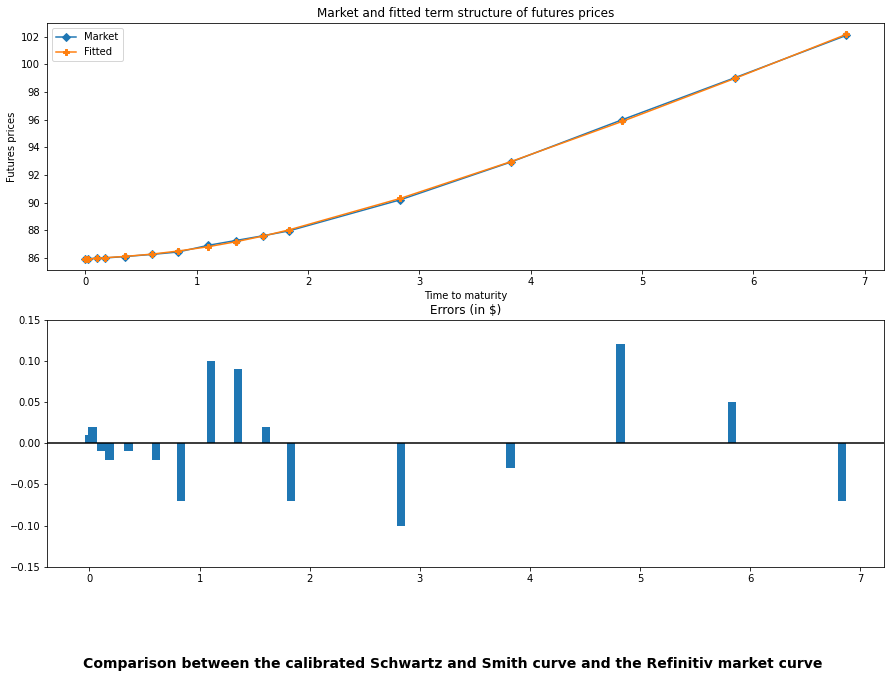

In [11]:
# Comparison between market prices and Schwartz and Smith model 
trade_date = EUA['Trade date']
maturity = EUA['Contract expiry']
forwards = EUA['Close prices']

maturities = calc_maturities(maturity, trade_date)

fitted, SSE = calc_schwartz(maturities, forwards, results.x)
fitted = round(fitted, 2)
Errors = forwards - fitted

# New dataframe with all inputs
summary = pd.concat([maturities, forwards, fitted, Errors], axis = 1)
summary.columns = ['maturities', 'forwards', 'fitted', 'Errors']
summary.set_index('maturities', inplace = True)

# Plot
fig, ax = plt.subplots(2, figsize = (15, 10))

ax[0].plot(summary.forwards, 'D-');
ax[0].plot(summary.fitted, 'P-');
ax[0].set_xlabel("Time to maturity")
ax[0].set_ylabel("Futures prices")

plt.bar(summary.index, summary.Errors, 0.075);
ax[1].set_ylim(-0.15, 0.15)
plt.axhline(y = 0, color = 'black')

ax[0].legend(['Market', 'Fitted'])

ax[0].set_title('Market and fitted term structure of futures prices')
ax[1].set_title('Errors (in $)')
fig.suptitle('Comparison between the calibrated Schwartz and Smith curve and the Refinitiv market curve', 
             fontweight = 'bold', size = 14, y = 0);

In [37]:
# Discount factors
from datetime import datetime

Settlement_date, err = ek.get_data(['CFI2Z2'], ['EXPIR_DATE'])             # Settlement date defined as DEC2022
Fwd_maturity = Settlement_date['EXPIR_DATE']
Fwd_maturity = datetime.strptime(Fwd_maturity.iloc[0], '%Y-%m-%d')

NameError: name 'datetime' is not defined

In [ ]:
import datetime

# Check if today is a business day, otherwise return the last business day
def is_business_day(date):
    if bool(len(pd.bdate_range(date, date))):
        return date
    else:
        offset = max(1, (date.weekday() + 6) % 7 - 3)
        date = date - datetime.timedelta(offset) 
    return date

today = datetime.datetime.today()
today = is_business_day(today)